In [1]:
import pandas as pd
import numpy as np
from tsmoothie.smoother import LowessSmoother
from scipy.signal import correlate
from scipy.stats import shapiro
import plotly.express as px
import plotly.graph_objects as go
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, KBinsDiscretizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense
import statsmodels.api as sm
from statsmodels.api import OLS
import catboost as cb
import xgboost as xgb
import datetime
import pickle

pd.set_option('display.max_columns', None)

## Reading in data and preparing for merging

In [2]:
# Cases data
cases = pd.read_csv("./cases_sold.csv")

# Inventory data
inv = pd.read_csv("./inventory.csv")
inv['BRNCH_CD'] = inv['BRNCH_CD'].astype('string')
inv['TEMP_ZONE'] = inv['TEMP_ZONE'].astype('string')
inv['TEMP_ZONE'] = inv['TEMP_ZONE'].replace(['CLR', 'DRY', 'FRZ'], ['Refrigerated', 'Dry', 'Freezer'])
inv = inv.groupby(['FISC_YR_WK', 'BRNCH_CD']).agg(sum).reset_index()

# Spoilage data
spoilage = pd.read_csv("./spoilage.csv")
spoilage['TEMP_ZONE'] = spoilage['TEMP_ZONE'].replace(['CLR', 'DRY', 'FRZ'], ['Refrigerated', 'Dry', 'Freezer'])
spoilage = spoilage.groupby(['FISC_YR_WK', 'BRNCH_CD']).agg(sum).reset_index()

# Slot utilization data
slot_util = pd.read_csv("./Slot Utilization.csv")
slot_util['DATE_EXTRACT'] = pd.to_datetime(slot_util['DATE_EXTRACT'])

# Remove rows with no capacity and where branches are equal to X1, X6, or X7 and not stock yards
slot_util = slot_util[slot_util['CAPACITY'].notna()]
slot_util = slot_util[~slot_util['BRNCH_CD'].isin(['X1', 'X6', 'X7'])]
slot_util = slot_util[~slot_util['FULL_MARKET_NAME'].str.contains('STOCK YARDS')]
slot_util_main = slot_util[slot_util['CAPACITY'] != 0]

## Removing manually identified outlier time periods (e.g. extreme capacity values in first few weeks of warehouse opening)

In [3]:
# Note time periods and branchs below were manually selected by looking at capacity over time plots on the EDA dashboard
branchs = ['9A', '9J', '8A', '5T', '8T', '9Q', '8B', '4P']
period_start = ['2021-04-08', '2021-03-19', '2021-11-30', '2021-06-30', '2021-08-11', '2022-02-08', '2021-10-12', '2022-03-31']
period_end = ['2021-04-23', '2021-03-31', '2021-12-04', '2021-08-05', '2021-08-20', '2022-02-09', '2021-10-22', '2022-06-19']

# Removing above time periods for selected branches
for i, brnch in enumerate(branchs):
    slot_util = slot_util[~((slot_util['BRNCH_CD'] == brnch) & (slot_util['DATE_EXTRACT'] >= period_start[i]) & 
                            (slot_util['DATE_EXTRACT'] <= period_end[i]))]

# Removing week of 2021-11-28 (very odd outlier)
slot_util = slot_util[~(slot_util['DATE_EXTRACT'] == '2021-11-28')]

## Derived features

In [4]:
# Total number of pallet positions used by day and branch 
brnchs = slot_util.groupby(['DATE_EXTRACT', 'BRNCH_CD']).agg(np.sum).reset_index()
brnchs['CAPACITY'] = brnchs['SUM(PALLET_USED)'] / brnchs['SUM(PALLET_POSITIONS)']
brnchs = brnchs[['DATE_EXTRACT', 'BRNCH_CD', 'SUM(PALLET_USED)']]
brnchs = brnchs.rename(columns={'SUM(PALLET_USED)':'TOTAL_PALLETS_USED'})

# Max number and percentage of pallet positions that are virtual slots by week and branch
virt = slot_util.groupby(['DATE_EXTRACT', 'STORAGE_TYPE', 'BRNCH_CD']).agg(np.sum).reset_index()
virt = virt.merge(brnchs, how='left', on=['DATE_EXTRACT', 'BRNCH_CD'])
virt = virt[['DATE_EXTRACT', 'STORAGE_TYPE', 'BRNCH_CD', 'SUM(PALLET_USED)', 'TOTAL_PALLETS_USED']]
virt = virt.rename(columns={'SUM(PALLET_USED)':'VIRTUAL_SLOT_POSITIONS'})
virt = virt[virt['STORAGE_TYPE'] == 'Virtual Slot']
virt['PERC_VIRTUAL_SLOTS'] = virt['VIRTUAL_SLOT_POSITIONS'] / virt['TOTAL_PALLETS_USED']
fw_virt = virt['DATE_EXTRACT'].apply(lambda a : int(str(a.year) + str(a.week)))
virt['FISC_YR_WK'] = fw_virt
virt = virt.groupby(['FISC_YR_WK', 'BRNCH_CD']).agg(max).reset_index()
virt = virt[['FISC_YR_WK', 'BRNCH_CD', 'VIRTUAL_SLOT_POSITIONS', 'PERC_VIRTUAL_SLOTS']]
virt = virt.rename(columns={'VIRTUAL_SLOT_POSITIONS':'MAX_VIRTUAL_SLOT_POSITIONS', 
                            'PERC_VIRTUAL_SLOTS':'MAX_PERC_VIRTUAL_SLOTS'})

# Max number and percentage of slots that are actively being picked by week and branch
pick = slot_util.groupby(['DATE_EXTRACT', 'PICK_TYPE', 'BRNCH_CD']).agg(np.sum).reset_index()
pick = pick.merge(brnchs, how='left', on=['DATE_EXTRACT', 'BRNCH_CD'])
pick = pick[['DATE_EXTRACT', 'PICK_TYPE', 'BRNCH_CD', 'SUM(PALLET_USED)', 'TOTAL_PALLETS_USED']]
pick = pick.rename(columns={'SUM(PALLET_USED)':'PICK_POSITIONS'})
pick = pick[pick['PICK_TYPE'] == 'Pick']
pick['PERC_PICK'] = pick['PICK_POSITIONS'] / pick['TOTAL_PALLETS_USED']
fw_pick = pick['DATE_EXTRACT'].apply(lambda a : int(str(a.year) + str(a.week)))
pick['FISC_YR_WK'] = fw_pick
pick = pick.groupby(['FISC_YR_WK', 'BRNCH_CD']).agg(max).reset_index()
pick = pick[['FISC_YR_WK', 'BRNCH_CD', 'PICK_POSITIONS', 'PERC_PICK']]
pick = pick.rename(columns={'PICK_POSITIONS':'MAX_PICK_POSITIONS', 
                            'PERC_PICK':'MAX_PERC_PICK'})

## Merging data

In [5]:
# Adding fiscal year and week to slot_util data to allow merging with other tables
fw = slot_util['DATE_EXTRACT'].apply(lambda a : int(str(a.year) + str(a.week)))
slot_util['FISC_YR_WK'] = fw
slot_util = slot_util.groupby(['BRNCH_CD', 'FISC_YR_WK', 'DATE_EXTRACT', 'AREA']).agg(sum).reset_index()
slot_util = slot_util.drop('DATE_EXTRACT', axis=1)
slot_util = slot_util.groupby(['BRNCH_CD', 'FISC_YR_WK', 'AREA']).agg(np.mean).reset_index()
slot_util['CAPACITY'] = slot_util['SUM(PALLET_USED)'] / slot_util['SUM(PALLET_POSITIONS)']

# Merging slot utilization by week and branch
merged = slot_util.merge(cases, how='inner', on=['BRNCH_CD', 'FISC_YR_WK'], validate="m:1")
merged['DIV_NBR'] = merged['DIV_NBR'].fillna(0)

# Merge with derived virtual slot features
merged = merged.merge(virt, how='inner', on=['BRNCH_CD', 'FISC_YR_WK'])

# Merge with derived pick slot features
merged = merged.merge(pick, how='inner', on=['BRNCH_CD', 'FISC_YR_WK'])

# Dropping redundant or useless columns
final = merged.drop(['WAREHOUSE_LOCN', 'DIV_NBR', 'DIV_NM', 'SUM(PALLET_USED)'], axis=1)

In [6]:
final.head()

,BRNCH_CD,FISC_YR_WK,AREA,SUM(PALLET_POSITIONS),CAPACITY,CASES_SOLD,MAX_VIRTUAL_SLOT_POSITIONS,MAX_PERC_VIRTUAL_SLOTS,MAX_PICK_POSITIONS,MAX_PERC_PICK
0,2G,202110,Dry,11403.571429,0.806627,125766.5582,38.0,0.002127,8892.0,0.487828
1,2G,202110,Freezer,7327.714286,0.887979,125766.5582,38.0,0.002127,8892.0,0.487828
2,2G,202110,Refrigerated,3033.571429,0.793172,125766.5582,38.0,0.002127,8892.0,0.487828
3,2G,202111,Dry,11382.000000,0.802646,130699.0329,37.0,0.002073,8809.0,0.490418
4,2G,202111,Freezer,7256.000000,0.863837,130699.0329,37.0,0.002073,8809.0,0.490418


# Two sets of features - with and without derived features

In [7]:
x_with_derived = final.drop(['CAPACITY'], axis=1)
x_base = final.drop(['CAPACITY', 'MAX_PICK_POSITIONS', 'MAX_PERC_PICK', 
                     'MAX_VIRTUAL_SLOT_POSITIONS', 'MAX_PERC_VIRTUAL_SLOTS'], axis=1)
y = final['CAPACITY']
x_base.head()

,BRNCH_CD,FISC_YR_WK,AREA,SUM(PALLET_POSITIONS),CASES_SOLD
0,2G,202110,Dry,11403.571429,125766.5582
1,2G,202110,Freezer,7327.714286,125766.5582
2,2G,202110,Refrigerated,3033.571429,125766.5582
3,2G,202111,Dry,11382.000000,130699.0329
4,2G,202111,Freezer,7256.000000,130699.0329


<AxesSubplot:>

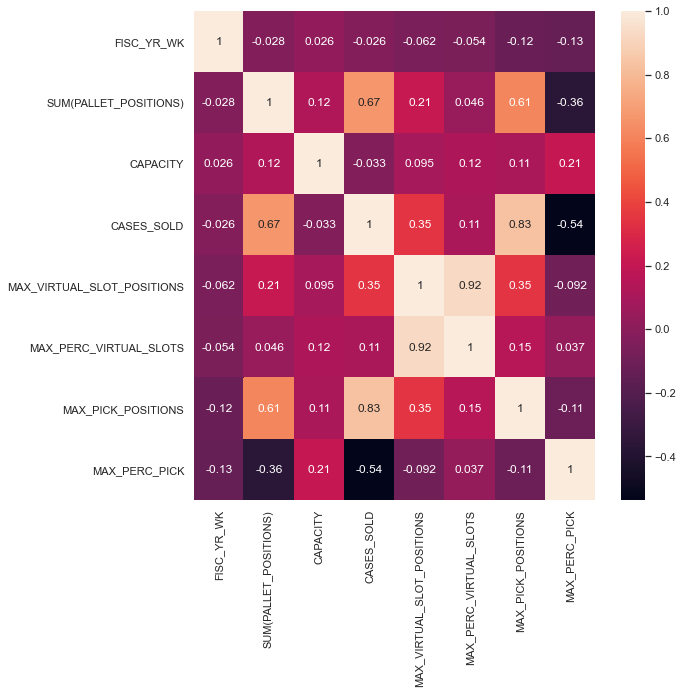

In [64]:
import seaborn as sns
sns.set(rc={"figure.figsize":(9,9)})
sns.heatmap(final.corr(), annot=True)

## Splitting data and defining standard preprocessing pipeline

In [48]:
# Selected features
x = x_with_derived

# Train/test split based on selected time period
train_start = min(x['FISC_YR_WK'])
train_end = max(x['FISC_YR_WK']) - 12
indices = (x['FISC_YR_WK'] >= train_start) & (x['FISC_YR_WK'] < train_end)
x = x.drop(['FISC_YR_WK'], axis=1)
x_train = x[indices]
x_test = x[~indices]
y_train = y[indices]
y_test = y[~indices]
x2 = x.drop(['BRNCH_CD'], axis=1)
x_train2 = x2[indices]
x_test2 = x2[~indices]

# Random train/test split
#x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=12345)

# Scoring method
scorer = make_scorer(mean_squared_error)

# Seed for cross validation
cv_seed = 918231

process_num_var = Pipeline(steps=[
    ('scaling', RobustScaler(with_centering=False))
    #('binning', KBinsDiscretizer(n_bins=10))
])

process_cat_var = Pipeline(steps=[
    ('dummy variables', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', process_num_var, x_train.columns[~x_train.columns.isin(['BRNCH_CD', 'AREA'])]),
        ('cat', process_cat_var, ['BRNCH_CD', 'AREA'])
    ])

preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', process_num_var, ['CASES_SOLD', 'SUM(PALLET_POSITIONS)'])
    ])

# Evaluation function - return RMSE on full test set as well as RMSE within each temperature zone
def evaluate(y_pred, y_val, x_val):
    frz_indices = x_val['AREA'] == 'Freezer'
    dry_indices = x_val['AREA'] == 'Dry'
    ref_indices = x_val['AREA'] == 'Refrigerated'
    full = np.sqrt(mean_squared_error(y_val, y_pred))
    frz = np.sqrt(mean_squared_error(y_val[frz_indices], y_pred[frz_indices]))
    dry = np.sqrt(mean_squared_error(y_val[dry_indices], y_pred[dry_indices]))
    ref = np.sqrt(mean_squared_error(y_val[ref_indices], y_pred[ref_indices]))
    out = {
        'Full RMSE':full,
        'Freezer RMSE':frz,
        'Dry RMSE':dry,
        'Refrigerated RMSE':ref
    }
    return out

## Comparing different models

In [49]:
# Baseline linear regression model
lm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('lm', LinearRegression())])
lm.fit(x_train, y_train)
res = cross_validate(lm, x_test, y_test, cv=KFold(n_splits=5, shuffle=True, random_state=cv_seed),
                                                    scoring=scorer)
print('OLS RMSE:', np.sqrt(np.mean(res['test_score'])))
print(evaluate(lm.predict(x_test), y_test, x_test))

OLS RMSE: 0.06361802592850285
{'Full RMSE': 0.06521092881721631, 'Freezer RMSE': 0.06020149718474393, 'Dry RMSE': 0.06793443813942229, 'Refrigerated RMSE': 0.06721672085878953}


In [50]:
# Penalized linear model
lasso = Pipeline(steps=[('preprocessor', preprocessor),
                      ('lm', Lasso())])
lasso.fit(x_train, y_train)
res = cross_validate(lasso, x_test, y_test, cv=KFold(n_splits=5, shuffle=True, random_state=cv_seed),
                                                    scoring=scorer)
print('Lasso RMSE:', np.sqrt(np.mean(res['test_score'])))
print(evaluate(lasso.predict(x_test), y_test, x_test))

Lasso RMSE: 0.13067703902859068
{'Full RMSE': 0.13063232263409083, 'Freezer RMSE': 0.12147698033745083, 'Dry RMSE': 0.1011662236505547, 'Refrigerated RMSE': 0.16187386938821263}


In [51]:
# Baseline decision tree model
dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('cart', DecisionTreeRegressor())])
dt.fit(x_train, y_train)
res = cross_validate(dt, x_test, y_test, cv=KFold(n_splits=5, shuffle=True, random_state=cv_seed),
                                                    scoring=scorer)
print('CART RMSE:', np.sqrt(np.mean(res['test_score'])))
print(evaluate(dt.predict(x_test), y_test, x_test))

CART RMSE: 0.030371180324138058
{'Full RMSE': 0.048793946468997915, 'Freezer RMSE': 0.03593995602550112, 'Dry RMSE': 0.057706738265830844, 'Refrigerated RMSE': 0.05020756472546981}


In [52]:
# Random forest model
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rf', RandomForestRegressor(n_estimators=500))])
rf.fit(x_train, y_train)
res = cross_validate(rf, x_test, y_test, cv=KFold(n_splits=5, shuffle=True, random_state=cv_seed),
                                                    scoring=scorer)
print('RF RMSE:', np.sqrt(np.mean(res['test_score'])))
print(evaluate(rf.predict(x_test), y_test, x_test))

RF RMSE: 0.022997040172627187
{'Full RMSE': 0.036340813461444764, 'Freezer RMSE': 0.029819207798266904, 'Dry RMSE': 0.04018027607842729, 'Refrigerated RMSE': 0.03818801421472078}


In [53]:
# Boosted trees model
parameters = {'boosted__n_estimators':[500, 1000, 2000, 3000], 
              'boosted__max_depth':[3, 5, 7]}
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('boosted', GradientBoostingRegressor())])
gs = GridSearchCV(pipe, parameters, n_jobs=4)
gs.fit(x_train, y_train)
print(gs.best_params_)
boost = Pipeline(steps=[('preprocessor', preprocessor),
                      ('boosted', GradientBoostingRegressor(n_estimators=gs.best_params_['boosted__n_estimators'],
                                                            max_depth=gs.best_params_['boosted__max_depth']))])
boost.fit(x_train, y_train)
res = cross_validate(boost, x_test, y_test, cv=KFold(n_splits=5, shuffle=True, random_state=cv_seed),
                                                    scoring=scorer)
print('sklearn Boosted Trees RMSE:', np.sqrt(np.mean(res['test_score'])))
print(evaluate(boost.predict(x_test), y_test, x_test))

{'boosted__max_depth': 3, 'boosted__n_estimators': 500}
sklearn Boosted Trees RMSE: 0.02533953615075663
{'Full RMSE': 0.03713011188634646, 'Freezer RMSE': 0.038476486677965306, 'Dry RMSE': 0.03418912783329524, 'Refrigerated RMSE': 0.03855644092751268}


In [38]:
# Boosted trees model (without branch)
parameters = {'boosted__n_estimators':[500, 1000, 2000, 3000], 
              'boosted__max_depth':[3, 5, 7]}
pipe = Pipeline(steps=[('preprocessor', preprocessor2),
                      ('boosted', GradientBoostingRegressor())])
gs = GridSearchCV(pipe, parameters, n_jobs=4)
gs.fit(x_train2, y_train)
print(gs.best_params_)
boost2 = Pipeline(steps=[('preprocessor', preprocessor2),
                      ('boosted', GradientBoostingRegressor(n_estimators=gs.best_params_['boosted__n_estimators'],
                                                            max_depth=gs.best_params_['boosted__max_depth']))])
boost2.fit(x_train2, y_train)
res = cross_validate(boost2, x_test, y_test, cv=KFold(n_splits=5, shuffle=True, random_state=cv_seed),
                                                    scoring=scorer)
print('sklearn Boosted Trees RMSE:', np.sqrt(np.mean(res['test_score'])))

{'boosted__max_depth': 7, 'boosted__n_estimators': 500}
sklearn Boosted Trees RMSE: 0.07150512000585084


In [ ]:
# XGBoost model
parameters = {'xgboost__n_estimators':[500, 1000, 2000, 3000], 
              'xgboost__learning_rate':[0.01, 0.001, 0.0001],
              'xgboost__max_depth':[10, 20, 25]}
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgboost', xgb.XGBRegressor())])
gs = GridSearchCV(pipe, parameters, n_jobs=4)
gs.fit(x_train, y_train)
xgb_fit = Pipeline(steps=[('preprocessor', preprocessor),
                          ('xgboost', xgb.XGBRegressor(n_estimators=gs.best_params_['xgboost__n_estimators'],
                                                      learning_rate=gs.best_params_['xgboost__learning_rate'],
                                                      max_depth=gs.best_params_['xgboost__max_depth']))])
xgb_fit.fit(x_train, y_train)
res = cross_validate(xgb_fit, x_test, y_test, cv=KFold(n_splits=5, shuffle=True, random_state=cv_seed),
                                                    scoring=scorer)
print('XGBoost RMSE:', np.sqrt(np.mean(res['test_score'])))

XGBoost RMSE: 0.025492819459601766


In [54]:
# Catboost model
# parameters = {'catboost__iterations':[100, 500, 1000, 2000, None], 
#               'catboost__learning_rate':[0.01, 0.001, 0.0001, None],
#               'catboost__depth':[5, 10, 20, None]}
# pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('catboost', cb.CatBoostRegressor(verbose=False))])
# gs = GridSearchCV(pipe, parameters, n_jobs=4)
# gs.fit(x_train, y_train)
# cat_fit = Pipeline(steps=[('preprocessor', preprocessor),
#                           ('catboost', cb.CatBoostRegressor(iterations=gs.best_params_['catboost__iterations'],
#                                                             learning_rate=gs.best_params_['catboost__learning_rate'],
#                                                             depth=gs.best_params_['catboost__depth']))])
cat_fit = Pipeline(steps=[('preprocessor', preprocessor),
                          ('catboost', cb.CatBoostRegressor(verbose=0, iterations=2000))])
cat_fit.fit(x_train, y_train)
res = cross_validate(cat_fit, x_test, y_test, cv=KFold(n_splits=5, shuffle=True, random_state=cv_seed),
                                                    scoring=scorer)
print('Catboost RMSE:', np.sqrt(np.mean(res['test_score'])))
print(evaluate(cat_fit.predict(x_test), y_test, x_test))

Catboost RMSE: 0.02107641148489564
{'Full RMSE': 0.02998194704433225, 'Freezer RMSE': 0.030015757235842846, 'Dry RMSE': 0.024848591143864816, 'Refrigerated RMSE': 0.03432715079104908}


In [43]:
# Selected model to use for forecasting
forecast_model = boost
forecast_model_no_branch = cat_fit

# Refitting models on entire dataset to use for forecasting
forecast_model.fit(x, y)
forecast_model_no_branch.fit(x2, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler(with_centering=False))]),
                                                  ['CASES_SOLD',
                                                   'SUM(PALLET_POSITIONS)'])])),
                ('catboost',
                 <catboost.core.CatBoostRegressor object at 0x0000022747620730>)])

In [106]:
# Forecast data
brnchs = merged.loc[:,['DIV_NBR', 'BRNCH_CD']].drop_duplicates()
final_pos = merged.loc[:,['BRNCH_CD', 'FISC_YR_WK', 'AREA']].groupby(['BRNCH_CD', 'AREA']).agg(max).reset_index()
final_pos = final_pos.merge(merged.loc[:,['BRNCH_CD', 'FISC_YR_WK', 'AREA', 'SUM(PALLET_POSITIONS)']]).drop('FISC_YR_WK', axis=1)
forecast = pd.read_csv('./current forecast.csv')
forecast = forecast.loc[:,['FISC_YR_WK', 'FORECAST', 'DIV_NBR']]
forecast = forecast.merge(brnchs, how='left')
forecast = forecast.merge(final_pos)
forecast = forecast.drop('DIV_NBR', axis=1)
forecast = forecast.rename({"FORECAST":"CASES_SOLD"}, axis=1)
forecast = forecast.dropna()
forecast.head(10)

,FISC_YR_WK,CASES_SOLD,BRNCH_CD,AREA,SUM(PALLET_POSITIONS)
0,202350,329921.82,4O,Dry,18522.875
1,202350,329921.82,4O,Freezer,12221.375
2,202350,329921.82,4O,Refrigerated,7131.375
3,202316,305104.00,4O,Dry,18522.875
4,202316,305104.00,4O,Freezer,12221.375
5,202316,305104.00,4O,Refrigerated,7131.375
6,202340,344966.22,4O,Dry,18522.875
7,202340,344966.22,4O,Freezer,12221.375
8,202340,344966.22,4O,Refrigerated,7131.375
9,202352,280637.21,4O,Dry,18522.875


In [107]:
# Capacity forecast made off of forecasted sales data
predicted = forecast_model.predict(forecast.drop('FISC_YR_WK', axis=1)[x_train.columns])
predicted_no_branch = forecast_model_no_branch.predict(forecast.drop(['FISC_YR_WK', 'BRNCH_CD'], axis=1)[x_train2.columns])
temp = forecast.copy()
forecast['CAPACITY'] = predicted
forecast['MODEL'] = 'With Branch'
temp['CAPACITY'] = predicted_no_branch
temp['MODEL'] = 'Without Branch'
forecast = pd.concat([forecast, temp])
forecast['DATE_EXTRACT'] = forecast['FISC_YR_WK'].apply(lambda a : datetime.datetime.strptime(f'{a//100}-W{a%100}-1', '%G-W%V-%u').date())
forecast = forecast.drop('FISC_YR_WK', axis=1)

In [108]:
# Model predictions on historical data
hist = x_base
predicted = forecast_model.predict(hist.drop('FISC_YR_WK', axis=1)[x_train.columns])
predicted_no_branch = forecast_model_no_branch.predict(hist.drop(['FISC_YR_WK', 'BRNCH_CD'], axis=1)[x_train2.columns])
hist['DATE_EXTRACT'] = hist['FISC_YR_WK'].apply(lambda a : datetime.datetime.strptime(f'{a//100}-W{a%100}-1', '%G-W%V-%u').date())
hist = hist.drop('FISC_YR_WK', axis=1)
temp = hist.copy()
hist['CAPACITY'] = predicted
hist['MODEL'] = 'With Branch'
print(hist['MODEL'].value_counts())
temp['CAPACITY'] = predicted_no_branch
temp['MODEL'] = 'Without Branch'
hist = pd.concat([hist, temp])
print(hist['MODEL'].value_counts())

With Branch    14862
Name: MODEL, dtype: int64
Without Branch    14862
With Branch       14862
Name: MODEL, dtype: int64


In [109]:
# Saving predictions for dashboard
all_preds = pd.concat([hist, forecast])
all_preds.to_csv("./forecasted_capacity.csv", index=False)
all_preds.head()

,BRNCH_CD,AREA,SUM(PALLET_POSITIONS),CASES_SOLD,DATE_EXTRACT,CAPACITY,MODEL
0,2G,Dry,11403.571429,125766.5582,2021-03-08,0.793253,With Branch
1,2G,Freezer,7327.714286,125766.5582,2021-03-08,0.869430,With Branch
2,2G,Refrigerated,3033.571429,125766.5582,2021-03-08,0.828003,With Branch
3,2G,Dry,11382.000000,130699.0329,2021-03-15,0.793967,With Branch
4,2G,Freezer,7256.000000,130699.0329,2021-03-15,0.869930,With Branch


In [77]:
# Confidence intervals
from scipy.stats import bayes_mvs
mean_confidence_interval, _, _ = bayes_mvs(predicted, alpha=0.95)
print("Predictions from model using branch as dummy var")
print("Mean:", mean_confidence_interval[0])
print("Confidence Interval:", mean_confidence_interval[1])
print()
mean_confidence_interval, _, _ = bayes_mvs(predicted_no_branch, alpha=0.95)
print("Predictions from model not using branch")
print("Mean:", mean_confidence_interval[0])
print("Confidence Interval:", mean_confidence_interval[1])

Predictions from model using branch as dummy var
Mean: 0.7708200676144769
Confidence Interval: (0.7695964495638712, 0.7720436856650825)

Predictions from model not using branch
Mean: 0.7757905839653509
Confidence Interval: (0.7748284463505789, 0.776752721580123)


In [24]:
# Pickling trained models
# Model without branch as dummy var
with open('pipeline_no_branch.pkl', 'wb') as f:
    pickle.dump(forecast_model_no_branch, f)

# Model with branch as dummy var
with open('pipeline_with_branch.pkl', 'wb') as f:
    pickle.dump(forecast_model, f)